# Client Project: Mapping Coronavirus Sentiment

Jonathan Cheung, Rahul Kaw, Wesley Miller, Roxana Ruvalcaba, 

## Problem Statement

Can we predict the severity of the COVID outbreak in a region using Twitter data? Specifically, can we accurately label and predict a tweet sentiment and is that information related to the COVID-19 outbreak severity?

The original problem statement stated that the data released regarding instances of the COVID-19 pandemic is aggregated before it is released to (legally and ethically) protect the privacy of those involved. Unfortunately, this takes away some of the utility of the data. The question we were to answer was, can the location of cases be narrowed further while still protecting privacy rights by using social media. 

## Executive Summary

Twitter data from California cities is currently not a good predictor of the Covid outbreak. To analyze the problem, we leveraged NLTK, sPacy, TextBlob, and Folium libraries to analyze tweet sentiment on a regional level and then to compare it to regional coronavirus cases data. For the first model, we used sPacy and nltk.opinion lexicon to label and predict tweet sentiment. For the second model, we used NLTK and TextBlob to label tweet sentiments then pipeline GridSearched a Logistic Regression to predict tweet sentiment. The tweets used as input for the models were pulled for seven California cities. The results of the first model were then plotted on a map with actual LA Times coronavirus data. The models did a good job predicting sentiment, however we did not find a strong relationship between tweet sentiment and Covid-19 outbreak cases. For next steps, we recommend gathering more data with location and further refine the sentiment labels. More details are located in the conclusion section.

# Contents

- [Imports](#Imports)
- [Model 1: sPacy + nltk.opinion_lexicon](#Model-1:-sPacy-+-nltk.opinion_lexicon)
- [Model 2: TextBlob + nltk](#Model-2:-TextBlob-+-nltk)
- [Conclusion](#Conclusion)

# Imports

### Setup all the libraries needed

In [7]:
#Python
import numpy as np
import pandas as pd
import time
import regex as reg
import os
from pathlib import Path
from collections import OrderedDict
from operator import itemgetter
#NLP
import spacy as sp
from nltk.corpus import opinion_lexicon
#sklearn
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#Serialization 
import dill
#Charts
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Mapping
import folium
from folium import plugins
from folium import plugins

# Import Tokenizer
from nltk.tokenize import RegexpTokenizer

# Process text
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, subjectivity
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

# Other models
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB


In [54]:
#dill.dump_session('tweet_sentiment.db')

# Model 1: sPacy + nltk.opinion_lexicon

### Import all the tweets from csv files into a DataFrame

In [2]:
len(opinion_lexicon.negative())
len(opinion_lexicon.positive())
#for w in range(len(opinion_lexicon.negative())):
#              opinion_lexicon.negative()[w]

4783

2006

In [21]:
filepath = '..'+os.sep+'Tweets_5_11/'
list_of_files = os.listdir(filepath)

In [22]:
tweet_df = pd.DataFrame()
for p in list_of_files:
    p = filepath + p
    temp_df = pd.read_csv(p,usecols = ['tweet_id','text','region'])
    tweet_df = tweet_df.append(temp_df)

In [23]:
tweet_df.head()

,tweet_id,text,region
0,1246588222903214080,Shaukat Khanum Memorial Cancer Hospital offers...,LA
1,1246587645779574784,Church congregants insisting on attending serv...,LA
2,1246585369899892738,Rendering of a new 44-unit affordable housing ...,LA
3,1246584511732695040,"Double date, covid-style. pic.twitter.com/LWh2...",LA
4,1246584386583068672,Si tuvieran que sacrificar un pueblo para acab...,LA


In [8]:
tweet_df.info()
tweet_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218684 entries, 0 to 457
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   tweet_id  218684 non-null  object
 1   text      218678 non-null  object
 2   region    218678 non-null  object
dtypes: object(3)
memory usage: 6.7+ MB


tweet_id    0
text        6
region      6
dtype: int64

In [9]:
tweet_df.drop_duplicates(subset = 'tweet_id',inplace=True)

In [10]:
tweet_df.head()

,tweet_id,text,region
0,1246588222903214080,Shaukat Khanum Memorial Cancer Hospital offers...,LA
1,1246587645779574784,Church congregants insisting on attending serv...,LA
2,1246585369899892738,Rendering of a new 44-unit affordable housing ...,LA
3,1246584511732695040,"Double date, covid-style. pic.twitter.com/LWh2...",LA
4,1246584386583068672,Si tuvieran que sacrificar un pueblo para acab...,LA


In [11]:
tweet_df.info()
tweet_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140596 entries, 0 to 1130
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   tweet_id  140596 non-null  object
 1   text      140592 non-null  object
 2   region    140592 non-null  object
dtypes: object(3)
memory usage: 4.3+ MB


tweet_id    0
text        4
region      4
dtype: int64

In [13]:
tweet_df.dropna(inplace=True)
tweet_df.info()
tweet_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140588 entries, 0 to 1130
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   tweet_id  140588 non-null  object
 1   text      140588 non-null  object
 2   region    140588 non-null  object
dtypes: object(3)
memory usage: 4.3+ MB


tweet_id    0
text        0
region      0
dtype: int64

In [14]:
tweet_df.reset_index(inplace=True,drop = True)
tweet_df = tweet_df.copy()

In [15]:
tweet_df.head()

,tweet_id,text,region
0,1246588222903214080,Shaukat Khanum Memorial Cancer Hospital offers...,LA
1,1246587645779574784,Church congregants insisting on attending serv...,LA
2,1246585369899892738,Rendering of a new 44-unit affordable housing ...,LA
3,1246584511732695040,"Double date, covid-style. pic.twitter.com/LWh2...",LA
4,1246584386583068672,Si tuvieran que sacrificar un pueblo para acab...,LA


### Import sPacy library for tokinzation and lemmatization of tweet text

In [16]:
spacy_nlp = sp.load('en_core_web_sm')
processed_tweet = []

def clean_tweet(text):

#replace anything that isn't a-z or A-Z with spaces including punctuations, exclamation etc
#replace 'https://', 'www.' by space 
    ret_str = ' '
    regex = r"(.\\n|.\\t|.\\r)|([0-9]+)|([^\w\s])|(https{0,1}:\/\/\S*)|(ww[wa-zA-Z0-9.com]+)|(pic.twitter\S*)"
    ret_str = reg.sub(regex, '', str(text))
    ret_str = ret_str.rstrip() 
    ret_str = ret_str.lstrip()
    ret_str = ret_str.lower()
    doc = spacy_nlp(ret_str)
    all_lemmas =  [token.lemma_ for token in doc if  not token.is_stop \
                   and token.is_alpha and token.lemma_ != '-PRON-']
    processed_tweet.append(" ".join(all_lemmas)) # tweet cleaned up,tokenized.Copy each tweet as a string to the list
    return all_lemmas #tweet cleaned up, tokenized return a list of tokens

In [17]:
def process_tweet():
    clean_tweets = []
    start = time.perf_counter()
    counter = 0
    for row in tweet_df['text']:
        clean_tweets.append(clean_tweet(row))
        counter += 1
        
    print(f"Processed {counter} rows in training data")

    end = time.perf_counter()

    print(f"Took { round((end-start)/60,0)} minutes to clean")
    return clean_tweets

In [18]:
tweet_tokens = process_tweet()

Processed 140588 rows in training data
Took 23.0 minutes to clean


### Engineer `sentiment` feature for each tweet by using `nltk.opinion_lexicon` corpus

In [19]:
count = 0 
sentiment = []
start = time.perf_counter()

for tokens in tweet_tokens:
    positive_words = 0
    negative_words = 0
    count += 1
    for i in range(len(tokens)):
        if tokens[i] in opinion_lexicon.positive():
            positive_words += 1
        elif tokens[i] in opinion_lexicon.negative():
            negative_words += 1
        
    if positive_words > negative_words:
        sentiment.append(1) #postive
    elif positive_words < negative_words:
        sentiment.append(-1) #negative
    elif positive_words == negative_words:
        sentiment.append(0) #neutral
        
    if count%10_000 == 0:
        print(f"Processed {count} rows")
            
end = time.perf_counter()
print(f"Took { round((end-start)/60,0)} minutes for sentiment analysis")          

len(sentiment)

Processed 10000 rows
Processed 20000 rows
Processed 30000 rows
Processed 40000 rows
Processed 50000 rows
Processed 60000 rows
Processed 70000 rows
Processed 80000 rows
Processed 90000 rows
Processed 100000 rows
Processed 110000 rows
Processed 120000 rows
Processed 130000 rows
Processed 140000 rows
Took 408.0 minutes for sentiment analysis


140588

In [20]:
tweet_df['tweettokens'] = tweet_tokens
tweet_df['processedtweet'] = processed_tweet
tweet_df['sentiment'] = sentiment

In [21]:
tweet_df.info()
tweet_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140588 entries, 0 to 140587
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tweet_id        140588 non-null  object
 1   text            140588 non-null  object
 2   region          140588 non-null  object
 3   tweettokens     140588 non-null  object
 4   processedtweet  140588 non-null  object
 5   sentiment       140588 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 6.4+ MB


,tweet_id,text,region,tweettokens,processedtweet,sentiment
0,1246588222903214080,Shaukat Khanum Memorial Cancer Hospital offers...,LA,"[shaukat, khanum, memorial, cancer, hospital, ...",shaukat khanum memorial cancer hospital offer ...,0
1,1246587645779574784,Church congregants insisting on attending serv...,LA,"[church, congregant, insist, attend, service, ...",church congregant insist attend service wake c...,0
2,1246585369899892738,Rendering of a new 44-unit affordable housing ...,LA,"[render, new, unit, affordable, housing, proje...",render new unit affordable housing project hav...,-1
3,1246584511732695040,"Double date, covid-style. pic.twitter.com/LWh2...",LA,"[double, date, covidstyle]",double date covidstyle,0
4,1246584386583068672,Si tuvieran que sacrificar un pueblo para acab...,LA,"[si, tuvieran, que, sacrificar, un, pueblo, pa...",si tuvieran que sacrificar un pueblo para acab...,0


In [22]:
tweet_df['sentiment'].value_counts(normalize = True)
# 0 - neutral, 1 - positive, -1 - negative

 0    0.379321
-1    0.325647
 1    0.295032
Name: sentiment, dtype: float64

### X,y variables and test train split

In [24]:
X = tweet_df['processedtweet']
y = tweet_df['sentiment']

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33,random_state = 111)
X_train.shape
X_test.shape
y_test.shape
y_train.shape

(94193,)

(46395,)

(46395,)

(94193,)

### Plot most frequent words found across all the tweets

In [26]:
def plot_words(x,y,color,title=''):
    plt.figure(figsize = (17,8))
    plt.style.use('fivethirtyeight')
    plt.xlabel('Words', {'fontsize': 14})
    plt.ylabel('Count',{'fontsize': 14})
    plt.xticks(fontsize = 14, rotation = 'vertical')
    plt.title('Top words ' + title , fontsize = 16)
    plt.bar(x,y, color = color)

In [52]:
def word_frequency(dataset,limit = 3000):

    word_freq = {}
    upper_limit = 0
    
    for s in dataset:
        string = s.split(' ')
        for w in string:
            if word_freq.get(w):
                word_freq[w] += 1
            else:
                word_freq[w] = 1

    #sort the word_freq dictionary in descending order            
    orderd_dict = OrderedDict(sorted(word_freq.items(), key=itemgetter(1), reverse = True))

    words =[]
    freq = []
    count = 0

    #only most frequent words else we will get a pretty long list of words
    for k,v in orderd_dict.items():
        if v > limit:
            words.append(k)
            freq.append(v)
    return words, freq

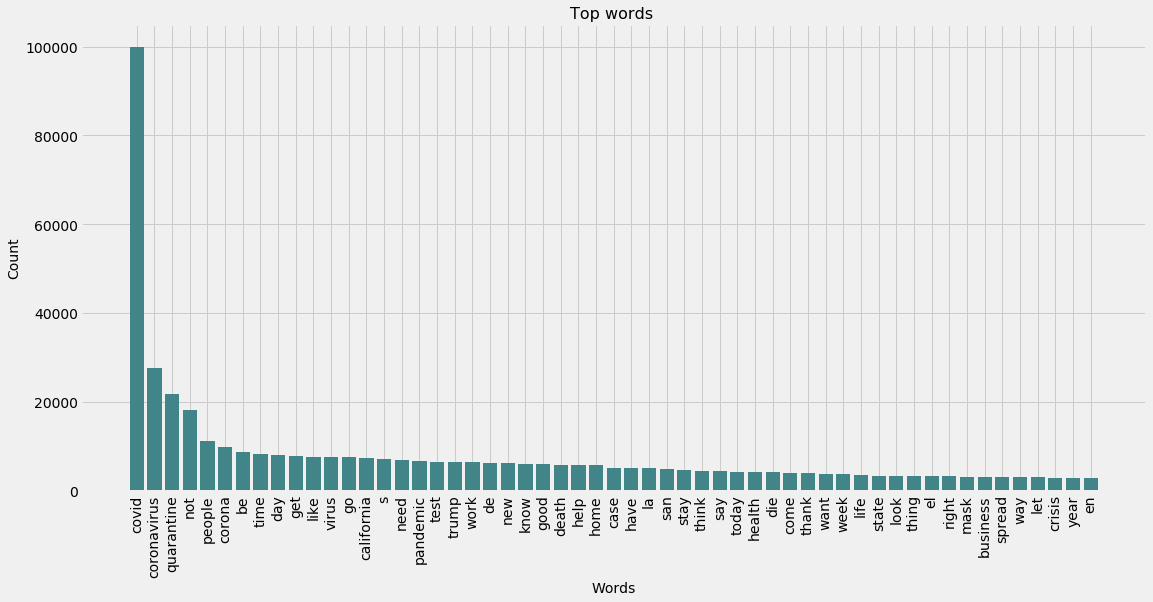

In [53]:
train_words, train_freq = word_frequency(tweet_df.processedtweet)
plot_words(train_words,train_freq,'#418588')

### Model building related.
### Actual vs predicted values
### Grid search function
### Pipeline and hyperparameter setup

In [35]:
def conf_matrix(gsobject,xdata,ydata):
    predicted = gsobject.predict(xdata)
    actual_predicted = pd.DataFrame({"Actual" : ydata, "Predicted": predicted, 'Text': xdata})
    return actual_predicted

In [36]:
#gs_type = grid search object
#xtraindata,xtestdata = xtrain and xtest 
#ytraindata,ytest = ytrain and ytest
def fit_grid_search(gs_type,xtraindata,ytraindata,xtestdata,ytestdata):
    start = time.perf_counter()
    gs_type.fit(xtraindata,ytraindata)
    print(f"Grid search accuracy for estimator \033[1m{gs_type.estimator.steps[1][0]}\033[0m "
          f"transformer \033[1m{gs_type.estimator.steps[0][0]}\033[0m : \n")
    print(f"On training data is {gs_type.score(xtraindata,ytraindata)}")
    print(f"On test data is {gs_type.score(xtestdata,ytestdata)}")
    print(f"Grid search best score (avg of cv scores) {gs_type.best_score_}\n\n")
    print(f"Model with best fitting parameter is \n {gs_type.best_estimator_.get_params}\n\n")
    #print(gs_type.best_estimator_.named_steps['logisticregression'].coef_)
    end = time.perf_counter()
    print(f"Took \033[1m{ round((end-start)/60,0)}\033[0m minutes to complete")
    cv_results_df = pd.DataFrame(gs_type.cv_results_)
    return cv_results_df,gs_type

In [37]:
pipette_tfidf = make_pipeline(TfidfVectorizer(),LogisticRegression())
pipe_params_tfidf = {
    'tfidfvectorizer__max_features': [15_000,25_000,30_000],
    'tfidfvectorizer__ngram_range': [ (1,2),(1,3)],
    'tfidfvectorizer__min_df' : [5,10], #discard words that appear in less than 5 or 10 documents
    'tfidfvectorizer__max_df' : [0.80], #exclude words that cross this threshold(how many documents contained a term)
    'tfidfvectorizer__stop_words' : [None],
    'logisticregression__max_iter': [1000]
}

### Grid search using `TfidfVectorizer` . Not using stop words as we have already run our tweets through stop word list above¶

In [38]:
gs_tfidf = GridSearchCV(pipette_tfidf, 
                  pipe_params_tfidf, 
                  cv = 5 ,
                  verbose = 1)

In [39]:
results_tfidf,gs_tfidf = fit_grid_search(gs_tfidf,X_train,y_train,X_test,y_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 15.7min finished


Grid search accuracy for estimator logisticregression transformer tfidfvectorizer : 

On training data is 0.8988778359326065
On test data is 0.8480439702554154
Grid search best score (avg of cv scores) 0.8342870395770585


Model with best fitting parameter is 
 <bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8, max_features=15000,
                                 min_df=5, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patte

### Actual sentiment vs predicted sentiment snapshot

In [40]:
print(f"\033[1mTraining set data\033[0m")
actual_v_predicted_train= conf_matrix(gs_tfidf,X_train,y_train)

mask = actual_v_predicted_train[(actual_v_predicted_train['Actual']) != (actual_v_predicted_train['Predicted'])]
mask

print(f"\033[1mTesting set data\033[0m")
actual_v_predicted_test = conf_matrix(gs_tfidf,X_test,y_test)

mask = actual_v_predicted_test[(actual_v_predicted_test['Actual']) != (actual_v_predicted_test['Predicted'])]
mask

Training set data


,Actual,Predicted,Text
1571,0,1,happy covid wednesday look get float stuffjust...
57792,0,1,not thank ioncardiff kit loan responsible appr...
79437,0,1,friend have conversation test covid despairing...
136634,0,1,world covid pandemic spread united state citiz...
78129,-1,0,try lifeinsurance pregnant pandemic ruackerman...
...,...,...,...
45567,1,-1,thought san francisco push release inmate la c...
61906,-1,0,shelter place pain ass s toilet paper store co...
17248,0,-1,covid kill wait hell greet trump supporter
104625,-1,0,relief strategy actually help worker small bus...


Testing set data


,Actual,Predicted,Text
19993,1,0,florida not care anybody beach throw massive p...
116916,0,-1,bitch crave intimacy quarantine
21000,0,-1,fivesnap cityoflosal rec dept comprehensive da...
131475,1,0,helpful interactive datum visualization tool t...
35486,1,0,new podcast limelight highlight mother day mir...
...,...,...,...
43198,0,-1,quarantine period hard reset life ask advantag...
130558,-1,0,progresso lowkey washing chunky canned soup ba...
40493,-1,0,local building industry adapt covid restrictio...
136417,1,0,impotus brief plan place trumpknewanddidnoth f...


### Gridsearch using `CountVectorizer` 
### Not using stop words as we have already run our tweets through stop word list above

In [41]:
pipette_cvect = make_pipeline(CountVectorizer(),LogisticRegression())
pipe_params_cvect = {
    'countvectorizer__max_features': [15_000,25_000,30_000],
    'countvectorizer__ngram_range':  [(1,2),(1,3)],
    'countvectorizer__min_df' : [5,10], #discard words that appear in less than 5 or 10 documents
    'countvectorizer__max_df' : [0.8], #exclude words that cross this threshold(how many docs contained a term)
    'countvectorizer__stop_words' : [None],
    'logisticregression__max_iter': [1000]
}

In [42]:
gs_cvect = GridSearchCV(pipette_cvect, 
                  pipe_params_cvect, 
                  cv = 5,
                  verbose = 1)

In [43]:
results_cvect,gs_cvect = fit_grid_search(gs_cvect,X_train,y_train,X_test,y_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 18.9min finished


Grid search accuracy for estimator logisticregression transformer countvectorizer : 

On training data is 0.9655282239656875
On test data is 0.9025541545425153
Grid search best score (avg of cv scores) 0.8866794848312635


Model with best fitting parameter is 
 <bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.8,
                                 max_features=15000, min_df=5,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('logist

### Actual sentiment vs predicted sentiment snapshot

In [44]:
print(f"\033[1mTraining set data\033[0m")
actual_v_predicted_train= conf_matrix(gs_cvect,X_train,y_train)

mask = actual_v_predicted_train[(actual_v_predicted_train['Actual']) != (actual_v_predicted_train['Predicted'])]
mask

print(f"\033[1mTesting set data\033[0m")
actual_v_predicted_test = conf_matrix(gs_cvect,X_test,y_test)

mask = actual_v_predicted_test[(actual_v_predicted_test['Actual']) != (actual_v_predicted_test['Predicted'])]
mask

Training set data


,Actual,Predicted,Text
1571,0,1,happy covid wednesday look get float stuffjust...
79437,0,1,friend have conversation test covid despairing...
43748,-1,0,lot available etsy have costume part insane pl...
118412,1,0,brilliant topical relatable substitute journal...
24514,0,1,great thread coronavirus complex system specia...
...,...,...,...
38899,-1,0,givingtuesdaynow emergency response covid time...
1898,1,0,girl not know invite real life birthday party ...
59298,0,1,not believe celebs sing song badly cure covid
104625,-1,0,relief strategy actually help worker small bus...


Testing set data


,Actual,Predicted,Text
19993,1,0,florida not care anybody beach throw massive p...
64923,0,-1,quarantine project waterproof old ugly fence s...
39134,0,1,eliud lagarda teach rd grade ocean view hill e...
116916,0,-1,bitch crave intimacy quarantine
21000,0,-1,fivesnap cityoflosal rec dept comprehensive da...
...,...,...,...
33237,0,1,geraldorivera like rest trump puppet look fool...
18469,1,0,effectiveness moral message public health beha...
43198,0,-1,quarantine period hard reset life ask advantag...
130558,-1,0,progresso lowkey washing chunky canned soup ba...


### Merge the `actual_v_predicted{train|test}` DataFrames into the original DataFrame 
### so that we can co-relate location for our predictions for eventual plotting on a map
### Write the merged DataFrame to a .csv file

In [45]:
output_df = pd.merge(tweet_df,actual_v_predicted_test[['Predicted']],how = 'left', left_index= True, right_index=True)
output_df = pd.merge(output_df,actual_v_predicted_train[['Predicted']],how = 'left', left_index= True, right_index=True)

In [46]:
output_df.head()
output_df.tail()
output_df.info()

,tweet_id,text,region,tweettokens,processedtweet,sentiment,Predicted_x,Predicted_y
0,1246588222903214080,Shaukat Khanum Memorial Cancer Hospital offers...,LA,"[shaukat, khanum, memorial, cancer, hospital, ...",shaukat khanum memorial cancer hospital offer ...,0,0.0,NaN
1,1246587645779574784,Church congregants insisting on attending serv...,LA,"[church, congregant, insist, attend, service, ...",church congregant insist attend service wake c...,0,NaN,0.0
2,1246585369899892738,Rendering of a new 44-unit affordable housing ...,LA,"[render, new, unit, affordable, housing, proje...",render new unit affordable housing project hav...,-1,-1.0,NaN
3,1246584511732695040,"Double date, covid-style. pic.twitter.com/LWh2...",LA,"[double, date, covidstyle]",double date covidstyle,0,NaN,0.0
4,1246584386583068672,Si tuvieran que sacrificar un pueblo para acab...,LA,"[si, tuvieran, que, sacrificar, un, pueblo, pa...",si tuvieran que sacrificar un pueblo para acab...,0,NaN,0.0


,tweet_id,text,region,tweettokens,processedtweet,sentiment,Predicted_x,Predicted_y
140583,1254934455317229574,Great virtual event on deck this week with @WI...,SD,"[great, virtual, event, deck, week, wisesandie...",great virtual event deck week wisesandiego wed...,1,NaN,1.0
140584,1254932501065199616,Maybe my quarantine journal will be screen gra...,SD,"[maybe, quarantine, journal, screen, grab, pro...",maybe quarantine journal screen grab proud twe...,1,1.0,NaN
140585,1254929997455749121,my dad has been growing a quarantine beard and...,SD,"[dad, grow, quarantine, beard, look, like, lor...",dad grow quarantine beard look like lord ring ...,1,NaN,1.0
140586,1254927732699353088,i would take a razor scooter to the ankle for ...,SD,"[razor, scooter, ankle, quarantine]",razor scooter ankle quarantine,0,NaN,0.0
140587,1254925467531898880,Eternal Summer is the song of the quarantine,SD,"[eternal, summer, song, quarantine]",eternal summer song quarantine,0,NaN,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140588 entries, 0 to 140587
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tweet_id        140588 non-null  object 
 1   text            140588 non-null  object 
 2   region          140588 non-null  object 
 3   tweettokens     140588 non-null  object 
 4   processedtweet  140588 non-null  object 
 5   sentiment       140588 non-null  int64  
 6   Predicted_x     46395 non-null   float64
 7   Predicted_y     94193 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 8.6+ MB


In [50]:
output_df.to_csv('model_loc_sentiment.csv',index = False)

# Model 2: TextBlob + nltk

### Data Gathering

In [8]:
filepath = '../Tweets_5_11/'
list_of_files = os.listdir(filepath)

In [9]:
list_of_files = list_of_files[1:]
list_of_files

['tweet_BAKERSFIELD_3_1_12.csv',
 'tweet_BAKERSFIELD_3_23_31.csv',
 'tweet_BAKERSFIELD_4_12_23.csv',
 'tweet_BAKERSFIELD_4_1_12.csv',
 'tweet_BAKERSFIELD_4_23_30.csv',
 'tweet_BAKERSFIELD_5_12_23.csv',
 'tweet_BAKERSFIELD_5_1_12.csv',
 'tweet_BAKERSFIELD_5_23_31.csv',
 'tweet_CHICO_3_14_27.csv',
 'tweet_CHICO_3_1_14.csv',
 'tweet_CHICO_3_27_31.csv',
 'tweet_CHICO_4_14_27.csv',
 'tweet_CHICO_4_1_14.csv',
 'tweet_LA_3_12_23.csv',
 'tweet_LA_3_1_12.csv',
 'tweet_LA_3_23_31.csv',
 'tweet_LA_4_12_23.csv',
 'tweet_LA_4_1_12.csv',
 'tweet_LA_4_23_30.csv',
 'tweet_LA_5_12_23.csv',
 'tweet_LA_5_1_12.csv',
 'tweet_REDDING_3_12_23.csv',
 'tweet_REDDING_3_14_27.csv',
 'tweet_REDDING_3_1_12.csv',
 'tweet_REDDING_3_1_14.csv',
 'tweet_REDDING_3_23_31.csv',
 'tweet_REDDING_3_27_31.csv',
 'tweet_REDDING_4_14_27.csv',
 'tweet_REDDING_4_1_12.csv',
 'tweet_REDDING_4_1_14.csv',
 'tweet_REDDING_4_27_30.csv',
 'tweet_REDDING_5_14_27.csv',
 'tweet_REDDING_5_1_14.csv',
 'tweet_SAC_3_14_27.csv',
 'tweet_SAC_3_1

In [37]:
tweets = pd.DataFrame()
for p in list_of_files:
    p = filepath + p
    temp_df = pd.read_csv(p, usecols = ['tweet_id','text','region'])
    tweets = tweets.append(temp_df)
    

### EDA

In [41]:
# drop duplicates
tweets.drop_duplicates(inplace = True)

# reset index
tweets.reset_index(drop = True, inplace = True)

In [42]:
tweets['region'].value_counts()

LA             47023
SF             42219
SD             28624
SAC            18984
BAKERSFIELD     3020
REDDING          939
CHICO            607
Name: region, dtype: int64

In [43]:
tweets.shape

(141420, 3)

In [44]:
# check nulls
tweets.isnull().sum()

tweet_id    0
text        4
region      4
dtype: int64

In [45]:
# removing nulls since there aren't many
tweets.dropna(inplace = True)

In [46]:
# text cleaning

def process_text(X):
    X_clean = []    
    counter = 0

    for train in X:
        X_clean.append(clean_text(train))
        counter += 1
    print(f"Processed {counter} rows in data")

    return X_clean


def clean_text(text):

#replace anything that isn't a-z or A-Z with spaces including punctuations, exclamation etc
#replace 'https://', 'www.' by space 
    ret_str = ' '
    regex = r"(.\\n|.\\t|.\\r)|([0-9]+)|([^\w\s])|(https{0,1}:\/\/\S*)|(ww[wa-zA-Z0-9.com]+)"
    ret_str = reg.sub(regex, '', str(text))
    ret_str = ret_str.rstrip() 
    ret_str = ret_str.lstrip()
    ret_str = ret_str.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    doc = tokenizer.tokenize(ret_str)
    lemmatizer = WordNetLemmatizer()
    all_lemmas =  [lemmatizer.lemmatize(token) for token in doc]
    return(" ".join(all_lemmas)) 

In [47]:
tweets['clean_text'] = process_text(tweets['text'])

Processed 141412 rows in data


In [48]:
# checking original vs clean text
tweets[['text', 'clean_text']].head()

,text,clean_text
0,Initially I thought this Covid-19 shit was a h...,initially i thought this covid shit wa a hoax ...
1,"Megan Person, Kern County Comms director, says...",megan person kern county comms director say th...
2,Lysol helps kill a regular coronavirus but DOE...,lysol help kill a regular coronavirus but doe ...
3,#Covid_19 FACT #2 addresses questions we’ve be...,covid_ fact address question weve been getting...
4,Ben Carson oh I sorry Dr. Ben Carson a neurosu...,ben carson oh i sorry dr ben carson a neurosur...


### Model: Labeling Sentiment with TextBlob

In [49]:
# predicting sentiment

clean_text = tweets['clean_text'].values.tolist()

from textblob import TextBlob
sentiment =[]

for i in range(len(clean_text)):
    sentiment.append(TextBlob(clean_text[i]).sentiment.polarity)

tweets['sentiment_score'] = sentiment

In [50]:
# placed sentiment scores into three buckets related to negative, neutral, and positive tweets
tweets['sentiment'] = tweets['sentiment_score'].apply(lambda x: 1 if x > 0 
                                                      else -1 if x < 0
                                                      else 0)

### Results of Sentiment Labels

In [51]:
# count of negative, neutral, and positive tweets
tweets.groupby(['region','sentiment'])['sentiment'].count()

region       sentiment
BAKERSFIELD  -1             700
              0            1072
              1            1248
CHICO        -1             145
              0             213
              1             249
LA           -1           10267
              0           15875
              1           20880
REDDING      -1             244
              0             328
              1             367
SAC          -1            4181
              0            6306
              1            8496
SD           -1            5695
              0           11317
              1           11611
SF           -1            8693
              0           14524
              1           19001
Name: sentiment, dtype: int64

### Model: Predicting Sentiment with Logistic Regression using sentiment labels from TextBlob model

In [52]:
# predicting sentiment with Logistic Regression

def grid_search_reddit_lr(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(), ngram = [(1,1), (2,2), (1,2)],
                       stop_w = ['english'], penalty = ['none', 'l2'], c = [0.2,0.5, 1,2,3], m_iter = [1000], max_d = [1.0], min_d = [1], max_f = [None], accents = [None]):
    
    # Define Pipeline - Remeber the step structure (list of tuple)
    pipe = Pipeline(steps = [('vectorizer', vectorizer),
                             ('model', LogisticRegression())
                              ])

    # Construct Grid Parameters
    hyperparams = {'vectorizer__ngram_range': ngram,
                   'vectorizer__stop_words': stop_w,
                   'vectorizer__max_df': max_d,
                   'vectorizer__min_df': min_d,
                   'vectorizer__max_features': max_f,
                   'vectorizer__strip_accents': accents,
                   'model__penalty': penalty,
                   'model__C': c,
                   'model__max_iter': m_iter
                  }

    # Perform Grid Search
    lr = GridSearchCV(pipe,
                     param_grid = hyperparams,
                     cv = 3,
                     scoring = 'accuracy')

    results = lr.fit(X_train, y_train)
    
    # Get score
    train_score = results.best_score_
    print('Best crossval score: {:.4f}'.format(train_score))
    train_score = results.score(X_train, y_train)
    print('Best TRAIN score: {:.4f}'.format(train_score))
    test_score = results.score(X_test, y_test)
    print('Best TEST score: {:.4f}'.format(test_score))
    print(results.best_params_)

    
    return lr

In [53]:
# train test split for X and y
X = tweets['clean_text']
y = tweets['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

print(X_train.shape)
print(y_train.shape)

(106059,)
(106059,)


### Results of Logistic Regression

In [54]:
lr = grid_search_reddit_lr(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(), penalty = ['l2'], 
                           max_f = [None], c = np.logspace(-3,3,7), stop_w = ['english'], ngram = [(1,1)])

/Users/RoxanaRuvalcaba/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/RoxanaRuvalcaba/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://

Best crossval score: 0.8456
Best TRAIN score: 0.9667
Best TEST score: 0.8578
{'model__C': 10.0, 'model__max_iter': 1000, 'model__penalty': 'l2', 'vectorizer__max_df': 1.0, 'vectorizer__max_features': None, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': 'english', 'vectorizer__strip_accents': None}


In [55]:
# checking words with highest and lowest coefficient
pd.DataFrame({'labels':lr.best_estimator_[0].get_feature_names(), 'coef':lr.best_estimator_[1].coef_[0]} ).sort_values('coef')

,labels,coef
9180,best,-11.110956
58931,lol,-9.916372
44153,happy,-7.368451
42767,great,-7.249388
54799,kind,-6.992867
...,...,...
44460,hate,14.411683
105773,stupid,15.179388
120890,worst,15.291498
7309,bad,15.887538


### Models and Results for specific Cities

In [56]:
# running a model for each individual city
def run_model(city):
    X = tweets[tweets['region'] == city]['clean_text']
    y = tweets[tweets['region'] == city]['sentiment']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    
    return grid_search_reddit_lr(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(), penalty = ['l2'], 
                                 max_f = [None], c = np.logspace(-3,3,7), stop_w = ['english'], ngram = [(1,1)])

In [57]:
lr_la = run_model('LA')
lr_sf = run_model('SF')
lr_bakersfield = run_model('BAKERSFIELD')
lr_redding = run_model('REDDING')
lr_sacramento = run_model('SAC')
lr_chico = run_model('CHICO')
lr_sd = run_model('SD')

Best crossval score: 0.8085
Best TRAIN score: 0.9858
Best TEST score: 0.8265
{'model__C': 10.0, 'model__max_iter': 1000, 'model__penalty': 'l2', 'vectorizer__max_df': 1.0, 'vectorizer__max_features': None, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': 'english', 'vectorizer__strip_accents': None}


/Users/RoxanaRuvalcaba/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/RoxanaRuvalcaba/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://

Best crossval score: 0.7990
Best TRAIN score: 0.9860
Best TEST score: 0.8076
{'model__C': 10.0, 'model__max_iter': 1000, 'model__penalty': 'l2', 'vectorizer__max_df': 1.0, 'vectorizer__max_features': None, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': 'english', 'vectorizer__strip_accents': None}
Best crossval score: 0.6684
Best TRAIN score: 0.9987
Best TEST score: 0.6967
{'model__C': 10.0, 'model__max_iter': 1000, 'model__penalty': 'l2', 'vectorizer__max_df': 1.0, 'vectorizer__max_features': None, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': 'english', 'vectorizer__strip_accents': None}
Best crossval score: 0.5924
Best TRAIN score: 1.0000
Best TEST score: 0.6085
{'model__C': 100.0, 'model__max_iter': 1000, 'model__penalty': 'l2', 'vectorizer__max_df': 1.0, 'vectorizer__max_features': None, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': 'english', 'vectorizer__strip_a

In [58]:
# creating a table with words with highest and lowest coefficient
coef_all = pd.DataFrame({'labels_all':lr.best_estimator_[0].get_feature_names(), 'coef_all':lr.best_estimator_[1].coef_[0]} ).sort_values('coef_all')
coef_la = pd.DataFrame({'labels_la':lr_la.best_estimator_[0].get_feature_names(), 'coef_la':lr_la.best_estimator_[1].coef_[0]} ).sort_values('coef_la')
coef_sf = pd.DataFrame({'labels_sf':lr_sf.best_estimator_[0].get_feature_names(), 'coef_sf':lr_sf.best_estimator_[1].coef_[0]} ).sort_values('coef_sf')
coef_bakersfield = pd.DataFrame({'labels_bakersfield':lr_bakersfield.best_estimator_[0].get_feature_names(), 'coef_bakersfield':lr_bakersfield.best_estimator_[1].coef_[0]} ).sort_values('coef_bakersfield')
coef_redding = pd.DataFrame({'labels_redding':lr_redding.best_estimator_[0].get_feature_names(), 'coef_redding':lr_redding.best_estimator_[1].coef_[0]} ).sort_values('coef_redding')
coef_sacramento = pd.DataFrame({'labels_sacramento':lr_sacramento.best_estimator_[0].get_feature_names(), 'coef_sacramento':lr_sacramento.best_estimator_[1].coef_[0]} ).sort_values('coef_sacramento')
coef_chico = pd.DataFrame({'labels_chico':lr_chico.best_estimator_[0].get_feature_names(), 'coef_chico':lr_chico.best_estimator_[1].coef_[0]} ).sort_values('coef_chico')
coef_sd = pd.DataFrame({'labels_sd':lr_sd.best_estimator_[0].get_feature_names(), 'coef_sd':lr_sd.best_estimator_[1].coef_[0]} ).sort_values('coef_sd')


coef_all = pd.concat([coef_all[:5], coef_all[coef_all.shape[0]-5:]])
coef_la = pd.concat([coef_la[:5], coef_la[coef_la.shape[0]-5:]])
coef_sf = pd.concat([coef_sf[:5], coef_sf[coef_sf.shape[0]-5:]])
coef_bakersfield = pd.concat([coef_bakersfield[:5], coef_bakersfield[coef_bakersfield.shape[0]-5:]])
coef_redding = pd.concat([coef_redding[:5], coef_redding[coef_redding.shape[0]-5:]])
coef_sacramento = pd.concat([coef_sacramento[:5], coef_sacramento[coef_sacramento.shape[0]-5:]])
coef_chico = pd.concat([coef_chico[:5], coef_chico[coef_chico.shape[0]-5:]])
coef_sd = pd.concat([coef_sd[:5], coef_sd[coef_sd.shape[0]-5:]])


coef_all.reset_index(inplace=True)
coef_la.reset_index(inplace=True)
coef_sf.reset_index(inplace=True)
coef_bakersfield.reset_index(inplace=True)
coef_redding.reset_index(inplace=True)
coef_sacramento.reset_index(inplace=True)
coef_chico.reset_index(inplace=True)
coef_sd.reset_index(inplace=True)

data_frames = [coef_all, coef_la, coef_sf, coef_bakersfield, coef_redding, coef_sacramento, coef_chico, coef_sd]
all_coef = pd.concat(data_frames, axis=1, sort=False)
all_coef = all_coef.drop(columns = 'index')

all_coef


,labels_all,coef_all,labels_la,coef_la,labels_sf,coef_sf,labels_bakersfield,coef_bakersfield,labels_redding,coef_redding,labels_sacramento,coef_sacramento,labels_chico,coef_chico,labels_sd,coef_sd
0,best,-11.110956,best,-8.612465,best,-7.177913,quarantine,-2.728906,california,-2.756019,lol,-5.301551,love,-1.557111,best,-6.807339
1,lol,-9.916372,perfect,-7.749148,lol,-6.828943,lmao,-2.483114,pandemic,-2.646519,better,-4.818921,covid,-1.502755,lol,-6.608790
2,happy,-7.368451,great,-7.523916,love,-6.402142,best,-2.431992,want,-2.592323,best,-4.481535,right,-1.337226,beautiful,-5.972869
3,great,-7.249388,glad,-5.680232,great,-5.835043,lol,-2.298760,positive,-2.407744,sound,-4.349326,way,-1.334107,great,-5.393315
4,kind,-6.992867,happy,-5.269433,happy,-5.438727,great,-2.270936,hope,-2.341186,love,-4.026242,chico,-1.320988,healthy,-4.015574
5,hate,14.411683,crazy,11.566108,small,10.320121,ill,4.773500,mean,4.190793,crazy,9.125067,sick,2.107853,ill,9.318245
6,stupid,15.179388,hate,11.709069,hate,10.522386,shit,4.874586,fuck,4.197421,worst,9.333020,terrible,2.229484,fuck,9.327841
7,worst,15.291498,stupid,11.725162,bad,11.700892,stupid,5.119330,trouble,4.640203,ill,9.605593,long,2.288927,crazy,10.394134
8,bad,15.887538,bad,13.235349,worst,11.898780,bad,5.817475,shit,4.905138,bad,9.930992,people,2.369513,bad,10.919283
9,sick,18.640929,sick,15.154342,sick,13.681059,crazy,6.081983,sick,6.105253,sick,10.721147,shit,2.975647,sick,11.175476


# Conclusion

The models performed well in predicting the sentiment of a tweet once tweets were labeled as being negative, neutral or, positive. However, we were unable to find any clear relationships between twitter sentiment and the severity of an outbreak in a region, and thus couldn’t predict the severity of an outbreak through tweets. While labeling sentiment, there were many conflating factors getting in the way of making any assertions regarding twitter sentiment’s relationship with coronavirus outcomes. As next steps, we recommend refining the tweet sentiment labels either by further cleaning the data or labeling manually if resources are available. Utilize additional computing power for modelling via an external resource, and gather data with more tweet locations. As additional tools, please also view the map prototypes the team created using actual coronavirus data from the LA Times.